In [ ]:
#loading necessary libraries
import pandas as pd
import ast
from collections import Counter
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns


/opt/anaconda3/envs/dissertation/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

      CENTRE       0.57      0.29      0.39       124
        LEFT       0.84      0.92      0.88       598
       RIGHT       0.52      0.53      0.52        59

    accuracy                           0.79       781
   macro avg       0.64      0.58      0.60       781
weighted avg       0.77      0.79      0.77       781

Confusion Matrix:
[[ 36  81   7]
 [ 23 553  22]
 [  4  24  31]]


<Figure size 600x500 with 0 Axes>

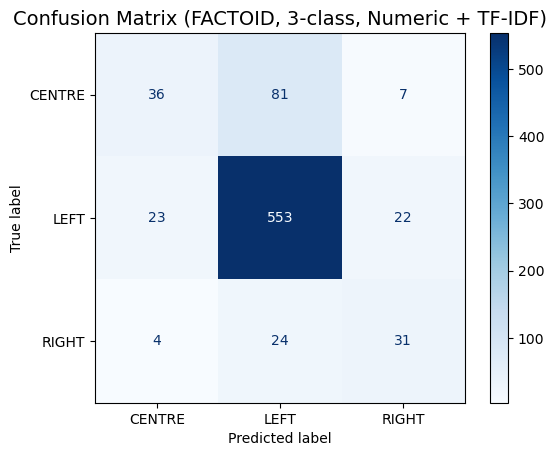

In [ ]:
path = "/Users/aniqakhan/Desktop/Dissertation/reddit_user_dataset.csv"  # adjust if needed
df = pd.read_csv(path)

# --- Extract dominant bias ---
def extract_dominant_bias(annotation_str):
    try:
        parsed = ast.literal_eval(annotation_str)
        tuples = [t for sublist in parsed for t in sublist if isinstance(t, tuple)]
        biases = [bias[0] for (_, _, bias, _) in tuples if bias and isinstance(bias, list)]
        if not biases:
            return None
        return Counter(biases).most_common(1)[0][0]
    except Exception:
        return None

df['dominant_bias'] = df['annotation'].apply(extract_dominant_bias)

# --- Map to 5 classes ---
bias_mapping_extreme = {
    'LEFT': 'EXTREME LEFT',
    'LEFT_CENTER': 'LEFT',
    'RIGHT': 'EXTREME RIGHT',
    'RIGHT_CENTER': 'RIGHT',
    'LEAST_BIASED': 'CENTRE',
    'PRO_SCIENCE': 'CENTRE'
}
df['polarisation_class'] = df['dominant_bias'].map(bias_mapping_extreme)
df = df.dropna(subset=['polarisation_class'])

# --- Collapse to 3 classes ---
collapse_map = {
    'EXTREME LEFT': 'LEFT',
    'LEFT': 'LEFT',
    'EXTREME RIGHT': 'RIGHT',
    'RIGHT': 'RIGHT',
    'CENTRE': 'CENTRE'
}
df['polarisation_class'] = df['polarisation_class'].map(collapse_map)

# --- Numeric features ---
exclude_cols = [
    'user_id', 'fake_news_spreader', 'documents', 'amounts',
    'embedding_file', 'annotation', 'dominant_bias', 'broad_political_leaning',
    'pb_factor', 'factual_factor'
]
num_features = [
    col for col in df.columns
    if col not in exclude_cols and df[col].dtype in [np.float64, np.int64]
]
X_num = df[num_features].replace([np.inf, -np.inf], np.nan).fillna(0)

# --- Text features ---
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
X_text = vectorizer.fit_transform(df['documents'].fillna(""))

# --- Combine numeric + text ---
X_combined = hstack([X_num, X_text])
y = df['polarisation_class']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# --- SMOTE oversampling ---
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# --- Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_res, y_res)

# --- Predictions ---
y_pred = rf.predict(X_test)

# --- Evaluation ---
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- Confusion Matrix Plot ---
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix (FACTOID, 3-class, Numeric + TF-IDF)', fontsize=14)
plt.show()

In [ ]:
#meta model code
from pathlib import Path
import joblib, pandas as pd

ROOT = Path.home() / "Desktop" / "Dissertation"
ARTF = ROOT / "factoid_artifacts"
ARTF.mkdir(parents=True, exist_ok=True)

#texts
fact_texts  = df['documents'].astype(str).fillna("")

#labels
fact_labels = (df['polarisation_class']
                 .astype(str)
                 .str.upper()
                 .str.replace("CENTER","CENTRE", regex=False)
                 .str.strip())

#classes
y = pd.Series(fact_labels)
if y.dtype.kind in "iuf":  # numeric codes
    num_map = {0:'LEFT', 1:'CENTRE', 2:'RIGHT'}
    y = y.map(num_map)
y = (y.astype(str)
       .str.upper()
       .str.replace("CENTER","CENTRE", regex=False))

assert set(y.unique()) <= {"LEFT","CENTRE","RIGHT"}, f"Unexpected labels: {set(y.unique())}"

#saving dataframe
pd.DataFrame({"text": fact_texts}).to_csv(ARTF / "factoid_train_text.csv", index=False)
y.to_csv(ARTF / "factoid_train_labels_3.csv", index=False, header=["label"])

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

model_factoid = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words="english"
    )),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )),
])

joblib.dump(model_factoid, ARTF / "factoid_pipeline.joblib")

print("Saved:", [p.name for p in ARTF.iterdir()])

Saved: ['factoid_train_labels_3.csv', 'factoid_train_text.csv', 'factoid_pipeline.joblib']
